In [1]:
# SKlearn library imports
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import learning_curve

# General libraries
from xarray import open_dataset
from xarray import merge
from numpy import zeros, linspace
from numpy import argwhere
from numpy import absolute
from matplotlib import pyplot as plt
import time

ModuleNotFoundError: No module named 'sklearn'

# Load flux site data

In [2]:
data_folder = "/Users/jb14389/Desktop/Flux_data/OZFlux2.0/OzFlux/"

site_name = "HowardSprings"

site_flux_file = site_name + "OzFlux2.0_flux.nc"
site_met_file  = site_name + "OzFlux2.0_met.nc"

flux_data = open_dataset(data_folder + site_flux_file)
met_data = open_dataset(data_folder + site_met_file)

print("-- Flux data --")
flux_data

-- Flux data --


<xarray.Dataset> Size: 16MB
Dimensions:           (x: 1, y: 1, time: 227904)
Coordinates:
  * x                 (x) float64 8B 1.0
  * y                 (y) float64 8B 1.0
  * time              (time) datetime64[ns] 2MB 2002-01-01T00:30:00 ... 2015-...
Data variables: (12/24)
    latitude          (y, x) float32 4B ...
    longitude         (y, x) float32 4B ...
    Qle               (time, y, x) float32 912kB ...
    Qh                (time, y, x) float32 912kB ...
    NEE               (time, y, x) float32 912kB ...
    GPP               (time, y, x) float32 912kB ...
    ...                ...
    elevation         (y, x) float32 4B ...
    reference_height  (y, x) float32 4B ...
    canopy_height     (y, x) float32 4B ...
    utc_offset        (y, x) timedelta64[ns] 8B ...
    averagePrecip     (y, x) float32 4B ...
    averageTemp       (y, x) float32 4B ...
Attributes: (12/17)
    Production_time:                  2016-03-08 16:44:40
    Production_source:                PALS netcdf conversion
    PALS_fluxtower_template_version:  1.0.2
    site_name:                        HowardSprings
    site_dataset_version:             2.0
    IGBP_vegetation_type:             Savanna
    ...                               ...
    OzFlux_soil_description:          red kandasol
    time_zone:                        Australia/Darwin
    OzFlux_processing_datetime:       2015-12-30 04:17:25
    Licence_type:                     TERN-BY-SA-NC
    Licence_URL:                      http://www.tern.org.au/datalicence/TERN...
    Acknowledgement:                  This work used eddy covariance data col...

In [3]:
print("\n-- Met data --")
met_data


-- Met data --


<xarray.Dataset> Size: 24MB
Dimensions:           (x: 1, y: 1, time: 227904, z: 1)
Coordinates:
  * x                 (x) float64 8B 1.0
  * y                 (y) float64 8B 1.0
  * time              (time) datetime64[ns] 2MB 2002-01-01T00:30:00 ... 2015-...
  * z                 (z) float64 8B 1.0
Data variables: (12/24)
    latitude          (y, x) float32 4B ...
    longitude         (y, x) float32 4B ...
    SWdown            (time, y, x) float32 912kB ...
    Tair              (time, z, y, x) float32 912kB ...
    Rainf             (time, y, x) float32 912kB ...
    Qair              (time, z, y, x) float32 912kB ...
    ...                ...
    elevation         (y, x) float32 4B ...
    reference_height  (y, x) float32 4B ...
    canopy_height     (y, x) float32 4B ...
    utc_offset        (y, x) timedelta64[ns] 8B ...
    averagePrecip     (y, x) float32 4B ...
    averageTemp       (y, x) float32 4B ...
Attributes: (12/17)
    Production_time:                  2016-03-08 16:44:32
    Production_source:                PALS netcdf conversion
    PALS_fluxtower_template_version:  1.0.2
    site_name:                        HowardSprings
    PALS_dataset_version:             2.0
    IGBP_vegetation_type:             Savanna
    ...                               ...
    OzFlux_soil_description:          red kandasol
    time_zone:                        Australia/Darwin
    OzFlux_processing_datetime:       2015-12-30 04:17:25
    Licence_type:                     TERN-BY-SA-NC
    Licence_URL:                      http://www.tern.org.au/datalicence/TERN...
    Acknowledgement:                  This work used eddy covariance data col...

# Data setup

Since this data only covers the one site we are going to drop all but the time dimention.

In [4]:
flux_data = flux_data.drop_vars(['x', 'y'])
met_data = met_data.drop_vars(['x', 'y', 'z'])

Next we drop the data columns that we definitly don't need. Note we retain the quality control flags for now.

In [5]:
# HowardSprings
columns_to_drop = ['latitude', 'longitude', 'elevation', 'reference_height', 'utc_offset', 'averagePrecip', 'averageTemp']

# Calperum
#columns_to_drop = ['latitude', 'longitude', 'reference_height', 'utc_offset', 'averageTemp']


flux_data = flux_data.drop_vars(columns_to_drop)
met_data  =  met_data.drop_vars(columns_to_drop)

We need to merge the two data sets on time.

In [6]:
data = merge([flux_data, met_data], join = 'inner')

data

<xarray.Dataset> Size: 38MB
Dimensions:        (time: 227904, y: 1, x: 1, z: 1)
Coordinates:
  * time           (time) datetime64[ns] 2MB 2002-01-01T00:30:00 ... 2015-01-01
Dimensions without coordinates: y, x, z
Data variables: (12/33)
    Qle            (time, y, x) float32 912kB ...
    Qh             (time, y, x) float32 912kB ...
    NEE            (time, y, x) float32 912kB ...
    GPP            (time, y, x) float32 912kB ...
    Qg             (time, y, x) float32 912kB ...
    SWup           (time, y, x) float32 912kB ...
    ...             ...
    Rainf_qc       (time, y, x) float64 2MB ...
    Qair_qc        (time, y, x) float64 2MB ...
    Wind_qc        (time, y, x) float64 2MB ...
    PSurf_qc       (time, y, x) float64 2MB ...
    CO2air_qc      (time, y, x) float64 2MB ...
    LWdown_qc      (time, y, x) float64 2MB ...
Attributes: (12/17)
    Production_time:                  2016-03-08 16:44:40
    Production_source:                PALS netcdf conversion
    PALS_fluxtower_template_version:  1.0.2
    site_name:                        HowardSprings
    site_dataset_version:             2.0
    IGBP_vegetation_type:             Savanna
    ...                               ...
    OzFlux_soil_description:          red kandasol
    time_zone:                        Australia/Darwin
    OzFlux_processing_datetime:       2015-12-30 04:17:25
    Licence_type:                     TERN-BY-SA-NC
    Licence_URL:                      http://www.tern.org.au/datalicence/TERN...
    Acknowledgement:                  This work used eddy covariance data col...

# Input selection

Now we want to chose which of the available data variables we want to use as input to the model.

We will also need to select GPP since this is the output we want to predict.

NOTE: We don't use Rainf as all of its values are flagged as unreliable (Rain_qc = 0.)

In [7]:
input_data = ['SWdown', 'Tair', 'Qair', 'Wind', 'PSurf', 'LWdown', 'CO2air']
prediction_targets = ['GPP']

selected_cols = input_data + prediction_targets
print(selected_cols)

['SWdown', 'Tair', 'Qair', 'Wind', 'PSurf', 'LWdown', 'CO2air', 'GPP']


# Cleaning data

We don't want to use data that, for whatever reason, is unreliable. To identify and subsiquently remove unreliable data entries we will make use of the quality control variables.

The quality control variables are noted by the sufix "_qc". Where a quality control entry has a value of one (zero) the value is considerd reliable (unreliable).

In [8]:
selected_cols_qc = []

# Itterate over all selected columns to crate list of quality control columns.
# Note Time doesn't have a quality contro column so we start at one to skip it.
for current in selected_cols:
    selected_cols_qc.append(current + "_qc")
    
print(selected_cols_qc)

['SWdown_qc', 'Tair_qc', 'Qair_qc', 'Wind_qc', 'PSurf_qc', 'LWdown_qc', 'CO2air_qc', 'GPP_qc']


We can sum over the quality control values for each time step. If one or more of those values are zero (indicating an unreliable entry) the total will be less than the number of quality control values. Only for time steps where the sum equals the total number of quality control values is all the data reliable enough to be used.

In [9]:
num_timesteps = len(data['time'])
qc_counter = zeros(num_timesteps)

for current_col in selected_cols_qc:
    qc_counter += data[current_col].to_numpy()[:,0,0]

reliable_timesteps = argwhere(qc_counter == len(selected_cols_qc))[:,0]
    
num_reliable_timesteps = len(reliable_timesteps)

num_removed_timesteps = num_timesteps - num_reliable_timesteps
percetage_reduction = 100 * num_removed_timesteps / num_timesteps

print(num_removed_timesteps, " of ", num_timesteps, "timesteps removed (", percetage_reduction,"%).")

data = data.isel(time=reliable_timesteps)

135593  of  227904 timesteps removed ( 59.495664841336705 %).


Having removed timesteps with unreliable values we reduce the data down to those columns we plan to use.

In [10]:
data = data[selected_cols]
data

<xarray.Dataset> Size: 4MB
Dimensions:  (time: 92311, y: 1, x: 1, z: 1)
Coordinates:
  * time     (time) datetime64[ns] 738kB 2002-03-14T15:30:00 ... 2014-12-31T1...
Dimensions without coordinates: y, x, z
Data variables:
    SWdown   (time, y, x) float32 369kB ...
    Tair     (time, z, y, x) float32 369kB ...
    Qair     (time, z, y, x) float32 369kB ...
    Wind     (time, z, y, x) float32 369kB ...
    PSurf    (time, y, x) float32 369kB ...
    LWdown   (time, y, x) float32 369kB ...
    CO2air   (time, z, y, x) float32 369kB ...
    GPP      (time, y, x) float32 369kB ...
Attributes: (12/17)
    Production_time:                  2016-03-08 16:44:40
    Production_source:                PALS netcdf conversion
    PALS_fluxtower_template_version:  1.0.2
    site_name:                        HowardSprings
    site_dataset_version:             2.0
    IGBP_vegetation_type:             Savanna
    ...                               ...
    OzFlux_soil_description:          red kandasol
    time_zone:                        Australia/Darwin
    OzFlux_processing_datetime:       2015-12-30 04:17:25
    Licence_type:                     TERN-BY-SA-NC
    Licence_URL:                      http://www.tern.org.au/datalicence/TERN...
    Acknowledgement:                  This work used eddy covariance data col...

The current data set contains measurments both during the day and at night. At night the amount of solar radiation (SWdown) available for photosynthesis is zero. There is hence no point trying to predict the GPP at such a time as, without sunlight, the GPP of the tree must be zero. We elect to remove all timesteps where the amount of sunlight (SWdown) is zero.

In [11]:
data = data.where(data['SWdown'] > 0, drop = True)
data

<xarray.Dataset> Size: 3MB
Dimensions:  (time: 76706, y: 1, x: 1, z: 1)
Coordinates:
  * time     (time) datetime64[ns] 614kB 2002-03-14T15:30:00 ... 2014-12-31T1...
Dimensions without coordinates: y, x, z
Data variables:
    SWdown   (time, y, x) float32 307kB 696.5 818.9 125.8 ... 807.9 983.5 820.1
    Tair     (time, z, y, x) float32 307kB 307.7 304.6 297.4 ... 304.1 304.1
    Qair     (time, z, y, x) float32 307kB 0.01606 0.01674 ... 0.01762 0.01707
    Wind     (time, z, y, x) float32 307kB 1.0 2.065 0.8592 ... 1.376 0.9986
    PSurf    (time, y, x) float32 307kB 1.006e+05 1.006e+05 ... 1.001e+05 1e+05
    LWdown   (time, y, x) float32 307kB 427.9 422.1 458.6 ... 420.8 418.4 415.7
    CO2air   (time, z, y, x) float32 307kB 345.8 343.7 362.0 ... 353.3 353.6
    GPP      (time, y, x) float32 307kB 18.99 14.59 5.975 ... 32.86 36.45 32.5
Attributes: (12/17)
    Production_time:                  2016-03-08 16:44:40
    Production_source:                PALS netcdf conversion
    PALS_fluxtower_template_version:  1.0.2
    site_name:                        HowardSprings
    site_dataset_version:             2.0
    IGBP_vegetation_type:             Savanna
    ...                               ...
    OzFlux_soil_description:          red kandasol
    time_zone:                        Australia/Darwin
    OzFlux_processing_datetime:       2015-12-30 04:17:25
    Licence_type:                     TERN-BY-SA-NC
    Licence_URL:                      http://www.tern.org.au/datalicence/TERN...
    Acknowledgement:                  This work used eddy covariance data col...

# Data normalisation

For a number of machine learning algorithms it is beneficial to normalise the data (convert the distribution of data in each column to simmilar scales). This is also necessary when comparing relevence scores. Before we can do this it is instructive to consider the range and distribution for each variable.

Note we don't need to normalise the predictor, here the GPP, so this is left out.

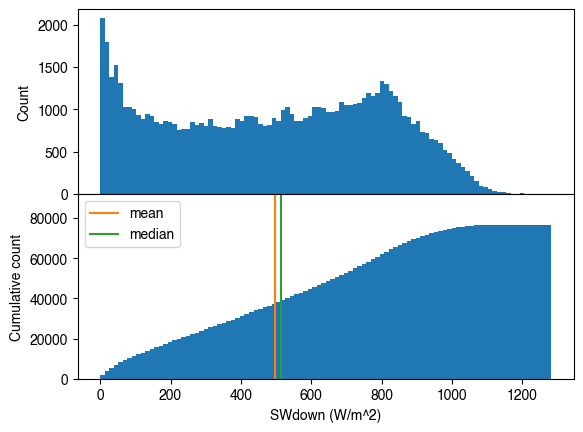

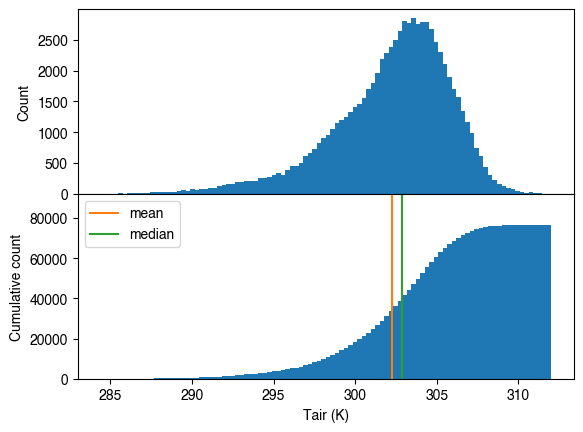

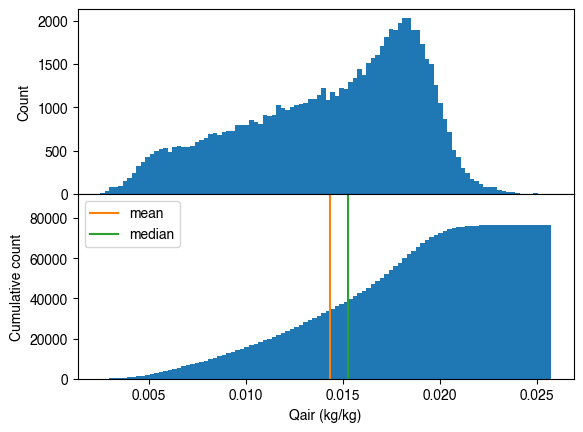

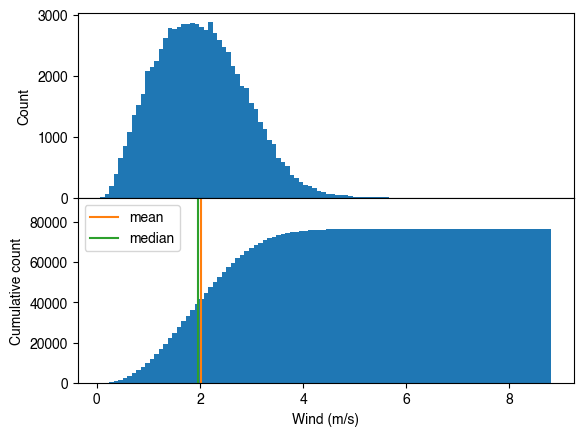

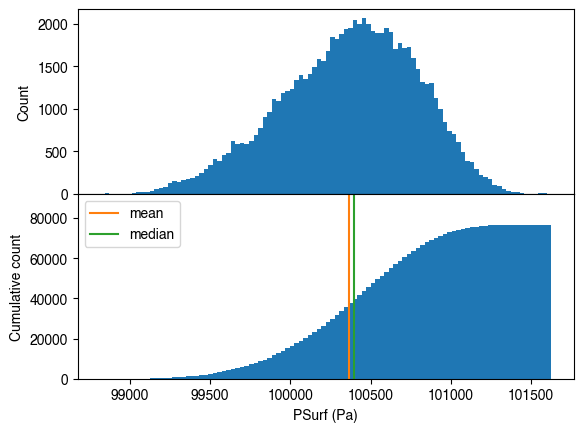

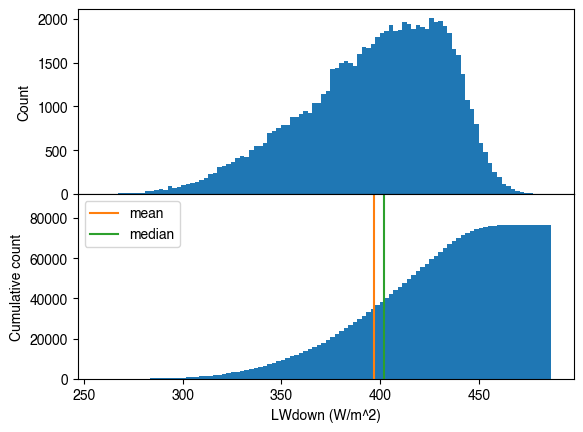

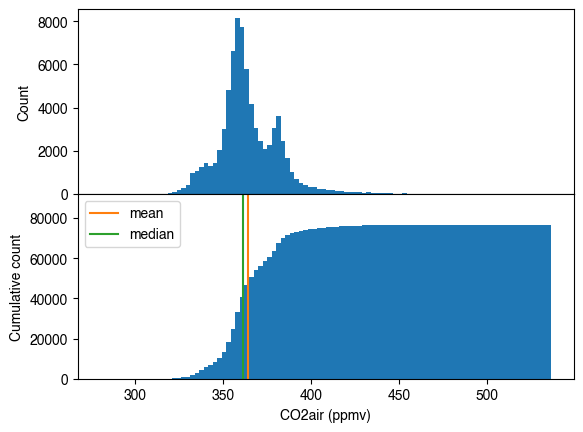

In [12]:
cumulative_count_range = 1.2 * len(data['time'])

means = data.mean()
median = data.median()
std = data.std()

# -- Plot the distribution of each column --
for col in selected_cols[:-1]:
    # Create figures
    fig, axs = plt.subplots(2, sharex = True)
    
    # Plot data
    axs[0].hist(data[col].values[:,0,0], bins = 100)
    axs[1].hist(data[col].values[:,0,0], bins = 100, cumulative = True)
    
    # Plot mean and median
    axs[1].plot([means[col], means[col]],[0,cumulative_count_range], label = 'mean')
    axs[1].plot([median[col], median[col]], [0,cumulative_count_range], label = 'median')
    
    # Format figures
    plt.subplots_adjust(hspace=0)
    
    axs[1].set_ylim(0,cumulative_count_range)
    
    axs[0].set_ylabel("Count")
    axs[1].set_ylabel("Cumulative count")
    plt.xlabel(col + " (" + data[col].attrs["units"] + ")")
    
    plt.legend()
    plt.show()

While there are a wide range of normalisation tecniques, here we choose to apply the z-score techique. This converts each value for a given column to the number of standard deviations it is from the mean of that column. The equation to convert from the measured value ot the normalised value is hence:

$$
x' = \frac{x-\mu}{\sigma}
$$

In [13]:
for col in selected_cols[:-1]:
    data[col] = (data[col] - means[col])/std[col]

Here we repeat the distribution plots but with the now normalised values.

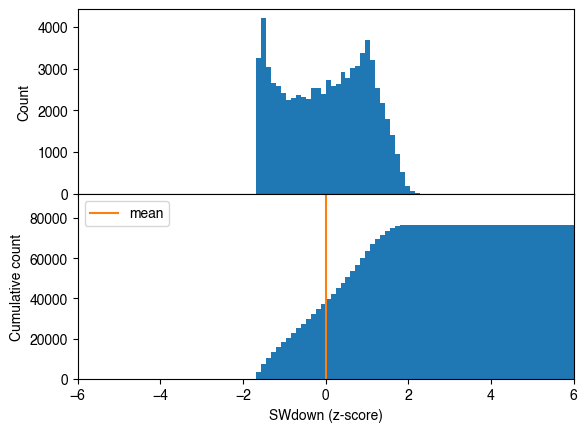

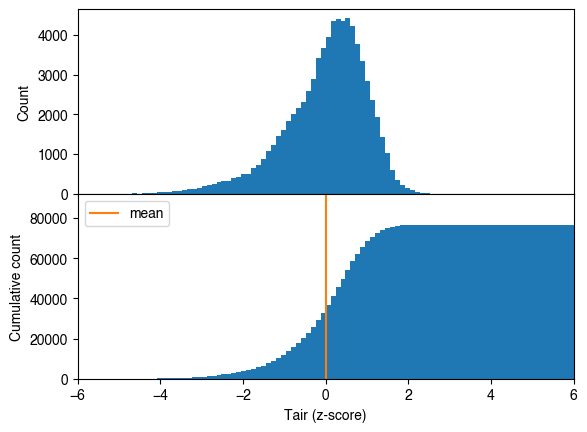

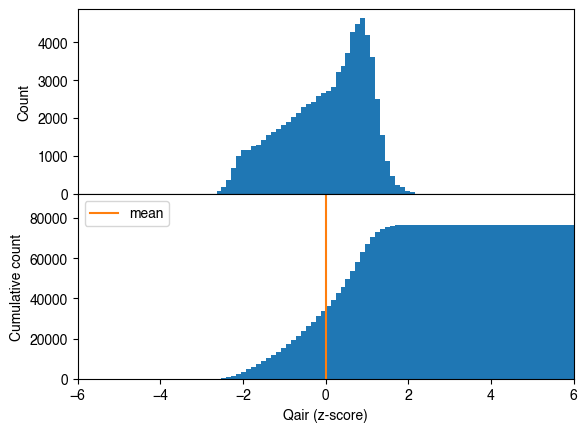

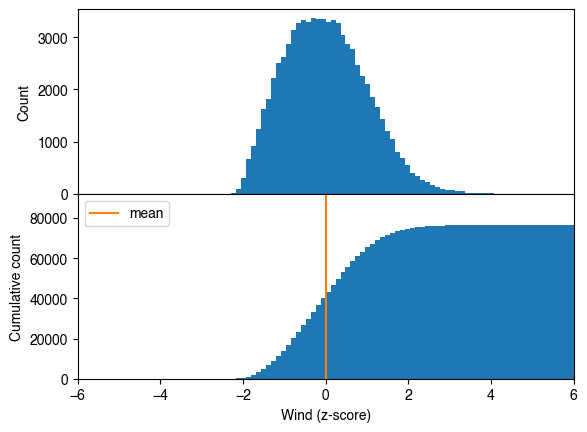

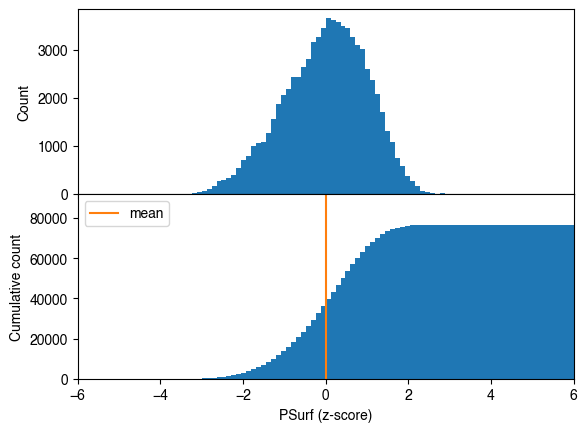

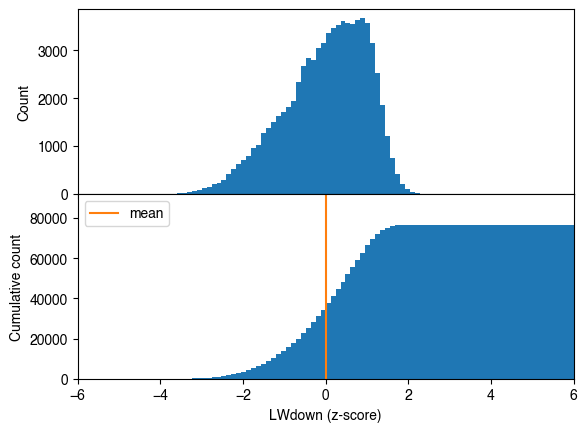

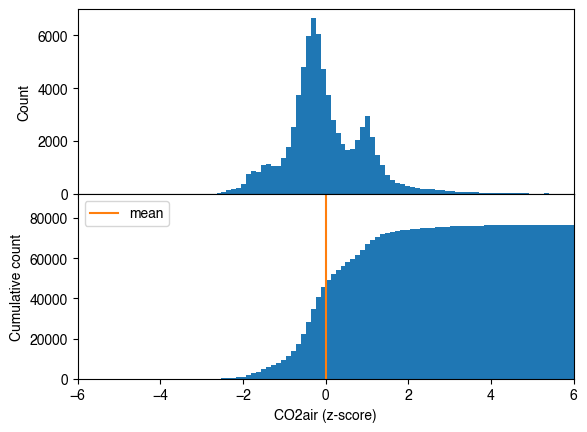

In [14]:
cumulative_count_range = 1.2 * len(data['time'])

min_zscore = -6
max_zscore = 6
bin_count = 101

bins = linspace(min_zscore, max_zscore, bin_count)

# -- Plot the distribution of each column --
for col in selected_cols[:-1]:
    # Create figures
    fig, axs = plt.subplots(2, sharex = True)
    
    # Plot data
    axs[0].hist(data[col].values[:,0,0], bins = bins)
    axs[1].hist(data[col].values[:,0,0], bins = bins, cumulative = True)
    
    # Plot mean and median
    axs[1].plot([0, 0],[0,cumulative_count_range], label = 'mean')
    
    # Format figures
    plt.subplots_adjust(hspace=0)
    
    axs[1].set_ylim(0,cumulative_count_range)
    plt.xlim(min_zscore, max_zscore)
    
    axs[0].set_ylabel("Count")
    axs[1].set_ylabel("Cumulative count")
    plt.xlabel(col + " (z-score)")
    
    plt.legend()
    plt.show()

The plots above show how normalisig the data removes the inherent scale differences in each measured property. Esentialy the act of normalising the data removes choice of units such that, rather than using different physical units for each input (e.g. degrees kelvin to Pascals), each input is 'measured' in z-score.

# Additional data cleaning

One potential problem shown by the plots above is the pressence of outlier values with z-scores that differ widly from zero. In other words they are a significant number of standard deviations from the mane. Large outliers can cause problems during training. Here we elect to remove those with an absolute z-score of more than four (i.e. they differ from the mean by more than four standard deviations).

In [15]:
old_count = len(data['time'])

for col in selected_cols[:-1]:
    data = data.where(absolute(data[col]) <= 4., drop = True)
    
# calculate howmany entries were removed in total
new_count = len(data['time'])
num_removed = old_count - new_count

print(num_removed, " of ", old_count, "timesteps removed")
    
data

530  of  76706 timesteps removed


<xarray.Dataset> Size: 5MB
Dimensions:  (time: 76176, y: 1, x: 1, z: 1)
Coordinates:
  * time     (time) datetime64[ns] 609kB 2002-03-14T15:30:00 ... 2014-12-31T1...
Dimensions without coordinates: y, x, z
Data variables:
    SWdown   (time, y, x, z) float64 609kB 0.6572 1.059 -1.215 ... 1.599 1.063
    Tair     (time, z, y, x) float64 609kB 1.501 0.6379 -1.349 ... 0.5055 0.5068
    Qair     (time, z, y, x) float64 609kB 0.3834 0.535 0.6121 ... 0.7321 0.6084
    Wind     (time, z, y, x) float64 609kB -1.182 0.05558 ... -0.7455 -1.184
    PSurf    (time, y, x, z) float64 609kB 0.5983 0.5273 ... -0.703 -0.8236
    LWdown   (time, y, x, z) float64 609kB 0.8633 0.7006 1.728 ... 0.5971 0.5217
    CO2air   (time, z, y, x) float64 609kB -1.084 -1.208 ... -0.6436 -0.6256
    GPP      (time, y, x, z) float32 305kB 18.99 14.59 5.975 ... 36.45 32.5
Attributes: (12/17)
    Production_time:                  2016-03-08 16:44:40
    Production_source:                PALS netcdf conversion
    PALS_fluxtower_template_version:  1.0.2
    site_name:                        HowardSprings
    site_dataset_version:             2.0
    IGBP_vegetation_type:             Savanna
    ...                               ...
    OzFlux_soil_description:          red kandasol
    time_zone:                        Australia/Darwin
    OzFlux_processing_datetime:       2015-12-30 04:17:25
    Licence_type:                     TERN-BY-SA-NC
    Licence_URL:                      http://www.tern.org.au/datalicence/TERN...
    Acknowledgement:                  This work used eddy covariance data col...

# Training, Validation and Testing split

For supervised learning it is necessary to split the data set into three entierly seperate components.

- Training set: The set of labled data on which the model is trained.
- Validation set: The set of data used to identify the optimal model structure (e.g. the number of decision trees in a random forist) and training stratergy (e.g. the size of the training dataset). 
- Test set: The set of data used to asses the model output. This data is not presented to the model during training.

An analogous way of thinking about this by comparing to a student learning a university coures;

- The training set is the lecture material. It is what the student (model) is explicitly taught.
- The validation set is the problem sheats. Is used under supervision to identify if the current approach to teaching the student (model) is working or needs to be changed before the final exam.
- The test set is the test at the end. It is used to asses the student (model) after the course (training). The content of the test (test set) needs to be novel (not in the traing or validation sets) inorder to test understanding (prediction).

How the data should be split depends on the data set and the system being modeld. Here we elect to use the data from 2010 onwards to create the test set.

Here we also convert the test data to a numpy array and create a sepperate array for the GPP labels.

In [16]:
test_data = data.sel(time=data['time.year'] > 2009)

test_data = test_data.to_array().to_numpy()

test_data = test_data[:,:,0,0,0]

test_data = test_data.T

test_data_GPP   = test_data[:, 7]
test_data_input = test_data[:,:7]

print("Test data:")
print("input: ", test_data_input.shape)
print("GPP: ", test_data_GPP.shape)

Test data:
input:  (37188, 7)
GPP:  (37188,)


The raminaing data from pre 2010 is used to create the training and validation data sets.

In [17]:
pre_2010_data = data.sel(time=data['time.year'] < 2010)

# convert xarray to numpy array (needed for train_test_split)
pre_2010_array = pre_2010_data.to_array().to_numpy()

# Remove unnecessary dimentions
pre_2010_array = pre_2010_array[:,:,0,0,0]

# Transpose array
pre_2010_array = pre_2010_array.T

# Split into GPP and input arrays
pre_2010_array_GPP   = pre_2010_array[:, 7]
pre_2010_array_input = pre_2010_array[:,:7]

validation_array_input, training_array_input, validation_array_GPP , training_array_GPP= train_test_split(pre_2010_array_input, pre_2010_array_GPP, test_size = 0.8 )

print("-- Training data --")
print("input: ", training_array_input.shape)
print("GPP: ", training_array_GPP.shape)

print("-- Validation data --")
print("input: ", validation_array_input.shape)
print("GPP: ", validation_array_GPP.shape)

-- Training data --
input:  (31191, 7)
GPP:  (31191,)
-- Validation data --
input:  (7797, 7)
GPP:  (7797,)


# Model creation and training

Now that we have a set of cleaned and normalised data that has been split into a training, validation and test set we can move onto the machine learning model.

For simplicity we are only going to use one machine learning model, specificaly a random forist regressor. Here we create the model with default hyper parameters (model properties chosen before training), and train it on the entirety of the training set.

In [18]:
RF_model = RandomForestRegressor()

RF_model.fit(training_array_input, training_array_GPP)

RandomForestRegressor()

Next we take the trained model and apply it to predict the normalised GPP for both the training and the validation data set.

We don't use the test set here as we may want to make changes to the models hyper parameters or the training method later.

In [19]:
training_array_predictions = RF_model.predict(training_array_input)
validation_array_predictions = RF_model.predict(validation_array_input)

To asses the acuracy of the random forest model's predictions the code bellow calculates the root mean squared error in the predicted GPP values.

In [20]:
RMS_error_training   = root_mean_squared_error(training_array_GPP,   training_array_predictions)
RMS_error_validation = root_mean_squared_error(validation_array_GPP, validation_array_predictions)

print("-- root mean square error --")
print("training:   ", RMS_error_training, "umol/m^2/s")
print("validation: ", RMS_error_validation, "umol/m^2/s")

-- root mean square error --
training:    1.7542781569938202 umol/m^2/s
validation:  4.790926646751849 umol/m^2/s


Imediatly we can see that the model provides a more acurate prediction when applied to the training data than the validation data. This is to be expected as the model was explicitly trained on the traing set and at this point has not seen the validation set.

To better compare the prediction to the ground truth the code bellow is used to plott a one to one comparison.

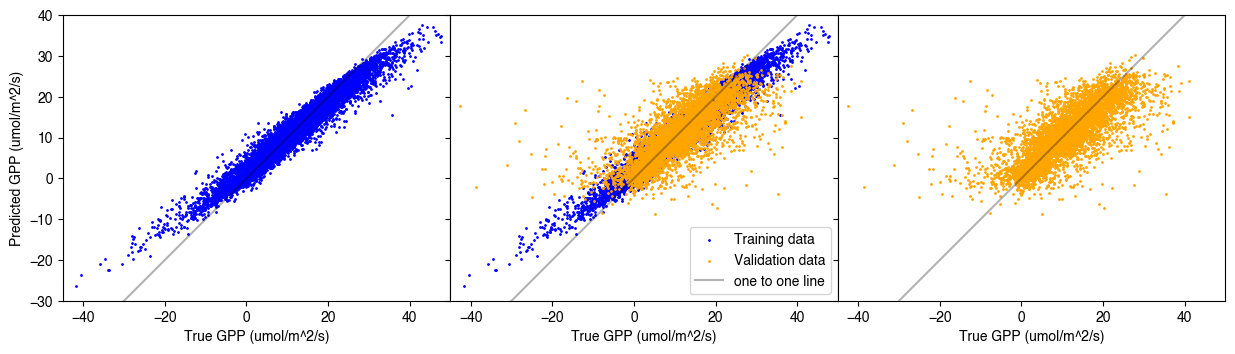

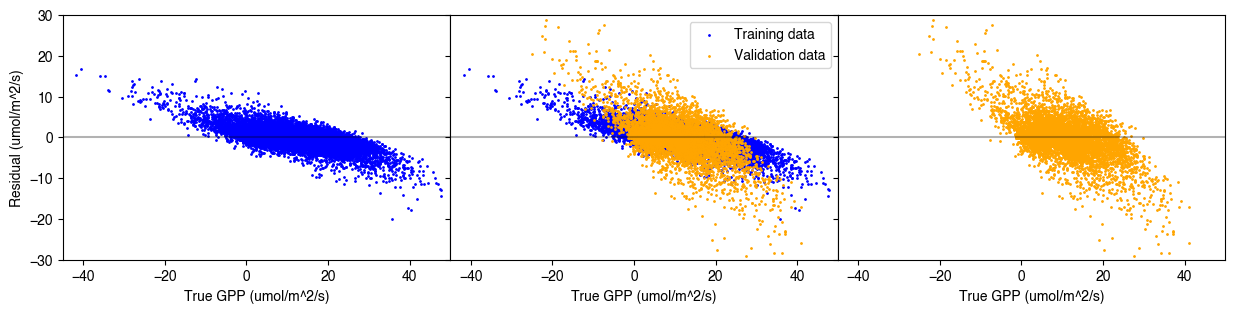

In [21]:
# Plot comparison of prediction to true GPP
fig, axs = plt.subplots(ncols = 3, sharex = True, sharey = True, figsize=(15, 15))
plt.subplots_adjust(wspace=0)

axs[0].scatter(training_array_GPP,   training_array_predictions,   s = 1, c = 'blue', label = 'Training data')
axs[1].scatter(training_array_GPP,   training_array_predictions,   s = 1, c = 'blue', label = 'Training data')
axs[1].scatter(validation_array_GPP, validation_array_predictions, s = 1, c = 'orange', label = 'Validation data')
axs[2].scatter(validation_array_GPP, validation_array_predictions, s = 1, c = 'orange', label = 'Validation data')

# Add one to one line
for i in range(len(axs)):
    axs[i].plot([-50,50],[-50,50], c = 'black', alpha = 0.3, label = 'one to one line')

# Format plot

for i in range(len(axs)):
    axs[i].set_aspect('equal')
    axs[i].set_xlabel("True GPP (umol/m^2/s)")
    
axs[1].legend()
plt.xlim(-45,50)
plt.ylim(-30,40)
axs[0].set_ylabel("Predicted GPP (umol/m^2/s)")
plt.show()


# Plot residuals of predicted to true GPP
fig, axs = plt.subplots(ncols = 3, sharex = True, sharey = True, figsize=(15, 15))
plt.subplots_adjust(wspace=0)

axs[0].scatter(training_array_GPP,   training_array_predictions - training_array_GPP,   s = 1, c = 'blue', label = 'Training data')
axs[1].scatter(training_array_GPP,   training_array_predictions - training_array_GPP,   s = 1, c = 'blue', label = 'Training data')
axs[1].scatter(validation_array_GPP, validation_array_predictions - validation_array_GPP, s = 1, c = 'orange', label = 'Validation data')
axs[2].scatter(validation_array_GPP, validation_array_predictions - validation_array_GPP, s = 1, c = 'orange', label = 'Validation data')

# Add one to one line
for i in range(len(axs)):
    axs[i].plot([-50,50],[0,0], c = 'black', alpha = 0.3)

# Format plot

for i in range(len(axs)):
    axs[i].set_aspect('equal')
    axs[i].set_xlabel("True GPP (umol/m^2/s)")
    
axs[1].legend()
plt.xlim(-45,50)
plt.ylim(-30,30)
axs[0].set_ylabel("Residual (umol/m^2/s)")
plt.show()

These plots reitterate what was shown by the RMS scorres, that the model is abble to better predict the GPP for the training data than the validation data. This is to be expected as the model has seen the training data before, while the validation data is new.

We can also see that the accuracy of the model's predicted GPP reduces as the true GPP shifts away from the mean and towards more sparcely populated extreams. This is a fairly common limitation of ML, accuracy tends to reduce in regions of parameter space that are sparsly populated by the training data.

# Improving the model

There are a number of hyper paramiters such as the number of decision trees within the random forest that we can change in order to optimise the model to the data. 

## Varying the number of trees in the forest

To start the code below varies the number of trees within the model and uses the validation data set to identify the optimal number.

In [22]:
tree_count = [10, 20, 40, 60, 100, 200, 300, 400, 500, 1000]

training_time = zeros(len(tree_count))
RMS_score_training = []
RMS_score_validation = []

for i in range(len(tree_count)):
    print("Current tree count: ", tree_count[i])
    
    # Create model
    current_model = RandomForestRegressor(n_estimators=tree_count[i])
    
    # Get start time
    training_time[i] = time.time()
    
    # TRain model
    current_model.fit(training_array_input, training_array_GPP)
    
    # Clacluste elapsed time
    training_time[i] = time.time() - training_time[i]
    
    # Make predictions
    training_prediction = current_model.predict(training_array_input)
    validation_prediction = current_model.predict(validation_array_input)
    
    # Calculate RMS score for each
    RMS_score_training.append(  root_mean_squared_error(training_array_GPP,   training_prediction))
    RMS_score_validation.append(root_mean_squared_error(validation_array_GPP, validation_prediction))

Current tree count:  10
Current tree count:  20
Current tree count:  40
Current tree count:  60
Current tree count:  100
Current tree count:  200
Current tree count:  300
Current tree count:  400
Current tree count:  500
Current tree count:  1000


Note the plotting code is seperated into the cell bellow so it can be change without the need to run the long training code above.

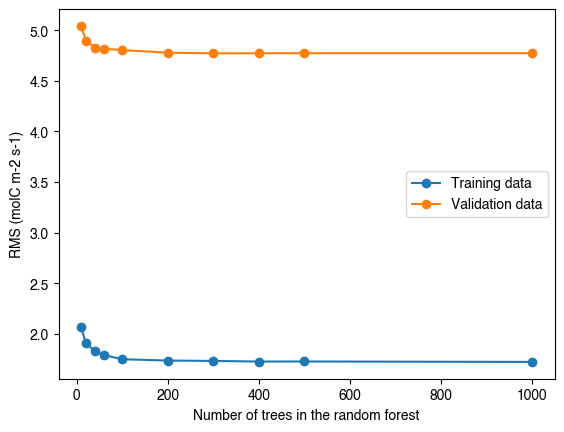

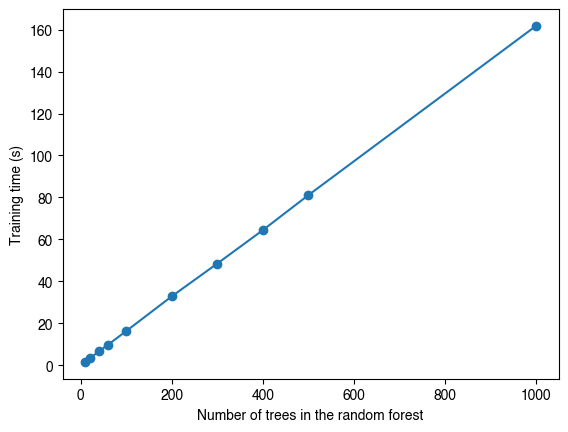

In [23]:
# Plot the change in RMS score
plt.plot(tree_count, RMS_score_training, label = 'Training data', marker = 'o')
plt.plot(tree_count, RMS_score_validation, label = 'Validation data', marker = 'o')

# Format plot
plt.xlabel("Number of trees in the random forest")
plt.ylabel("RMS (molC m-2 s-1)")
plt.legend()

plt.show()

# Plot the time taken to train
plt.plot(tree_count, training_time, marker = 'o')

# Format th plot
plt.xlabel("Number of trees in the random forest")
plt.ylabel("Training time (s)")

plt.show()

From these plots it is clear that above $100$ trees, there is a small improvement in the accuracy of the prediction when applied to the training data with effectivly no improvent for the validation data. Given the liniear increase in training time with number of trees there is no real benefit to using more than $\sim 100$ trees in the random forist.

## Varying the amount of training data

The code bellow varies the amount of examples used for training.

In [24]:
training_data_fraction = [0.1, 0.2, 0.4, 0.6, 0.8, 0.9, 1.]
training_data_count = []

for i in range(len(training_data_fraction)):
    training_data_count.append(int (training_data_fraction[i] * len(training_array_GPP)))

training_time = zeros(len(training_data_fraction))
RMS_score_training = []
RMS_score_validation = []

RF_model = RandomForestRegressor(n_estimators=100)

for i in range(len(training_data_count)):
    print("Current data count ",training_data_count[i])
    
    # Get start time
    training_time[i] = time.time()
    
    # TRain model
    current_model.fit(training_array_input[:training_data_count[i]], training_array_GPP[:training_data_count[i]])
    
    # Clacluste elapsed time
    training_time[i] = time.time() - training_time[i]
    
    # Make predictions
    training_prediction = current_model.predict(training_array_input)
    validation_prediction = current_model.predict(validation_array_input)
    
    # Calculate RMS score for each
    RMS_score_training.append(  root_mean_squared_error(training_array_GPP,   training_prediction))
    RMS_score_validation.append(root_mean_squared_error(validation_array_GPP, validation_prediction))

Current data count  3119
Current data count  6238
Current data count  12476
Current data count  18714
Current data count  24952
Current data count  28071
Current data count  31191


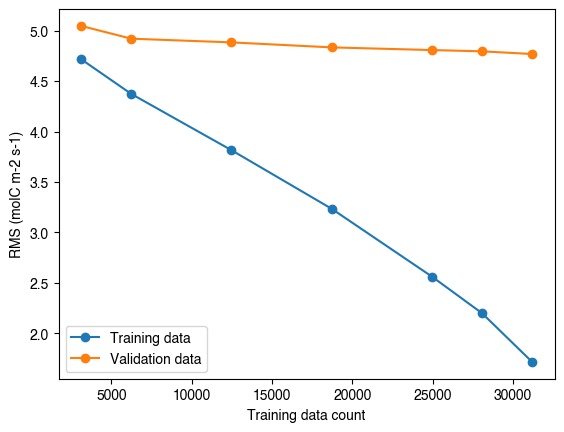

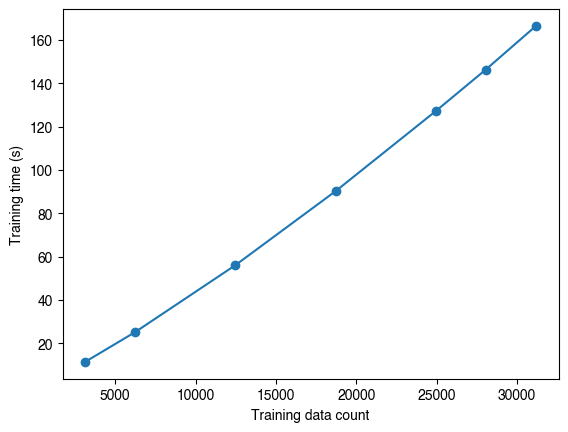

In [25]:
# Plot the change in RMS score
plt.plot(training_data_count, RMS_score_training, label = 'Training data', marker = 'o')
plt.plot(training_data_count, RMS_score_validation, label = 'Validation data', marker = 'o')

# Format plot
plt.xlabel("Training data count")
plt.ylabel("RMS (molC m-2 s-1)")
plt.legend()

plt.show()

# Plot the time taken to train
plt.plot(training_data_count, training_time, marker = 'o')

# Format th plot
plt.xlabel("Training data count")
plt.ylabel("Training time (s)")

plt.show()

We can see that the RMS score for both the training and validation set is decreasing as the size of the training set increases. It is clear however that the validation set is tending towards some minimum RMS. 